In [40]:
%reset -f

import pandas as pd
import numpy as np
import math as mt
import matplotlib.pyplot as plt

# Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils import plot_model

# SkLearn
import sklearn.preprocessing as SklPreProcessing
import sklearn.metrics as SklMetrics

%matplotlib inline

In [41]:
def conversion(inData, outData, inNames, outName='Y', n_in=1):
    n_vars = 1 if (type(inData) is list) or (len(inData.shape) == 1) else inData.shape[1]
    
    dfInput = pd.DataFrame(inData)
    dfOutput = pd.DataFrame(outData)
    
    cols, names = list(), list()
    
    for i in range(n_in, 0, -1):
        cols.append(dfInput.shift(i))
        cols.append(dfOutput.shift(i))
        names += [('%s(t-%d)' % (inNames[j], i)) for j in range(n_vars)]
        names += [('%s(t-%d)' % (outName, i))]
    
    cols.append(dfInput)
    cols.append(dfOutput)
    names += [('%s(t)' % inNames[j]) for j in range(n_vars)]
    names += [('%s(t)' % outName)]
    
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # Drop rows containing NaN values
    agg.dropna(inplace=True)
    return agg

In [42]:
def plotFeatures(featureData, featureNames):
    fig = plt.figure()
    fig.set_figwidth(10)
    fig.set_figheight(10)
    
    featureCount = len(featureNames)
    
    for i in range(featureCount):
        currAx = fig.add_subplot(featureCount, 1, i + 1)
        currAx.plot(featureData[:, i])
        currAx.set_title(featureNames[i])
        
    plt.show()    
    

In [43]:
# Load EEG data
eegDataRaw = np.genfromtxt('EEGEyeState.arff.csv', delimiter=',', skip_header=1)
eegHeader = np.genfromtxt('EEGEyeState.arff.csv', delimiter=',', max_rows=1, dtype=str)

eegInData = eegDataRaw[:, 0:14]
eegOutData = eegDataRaw[:, 14]

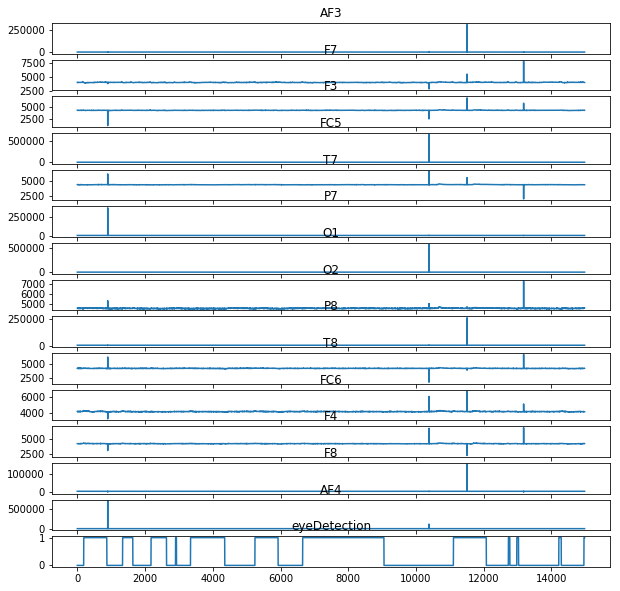

In [44]:
plotFeatures(eegDataRaw, eegHeader)

In [45]:
outLierIndexes = set()
upperLimit = 5000

featureCount = len(eegHeader)

for x in range(featureCount):
    outLiers = np.where(eegDataRaw[:, x] > upperLimit)[0]
    if len(outLiers) > 0:
        for i in xrange(len(outLiers)):
            outLierIndexes.add(outLiers[i])

outLierIndexes = list(outLierIndexes)
outLierIndexes.sort()
print 'Extreme outliers\nTotal:   ', len(outLierIndexes), \
    '\nIndexes: ', outLierIndexes

eegDataNoOutLiers = np.delete(eegDataRaw, outLierIndexes, 0)

Extreme outliers
Total:    4 
Indexes:  [898, 10386, 11509, 13179]


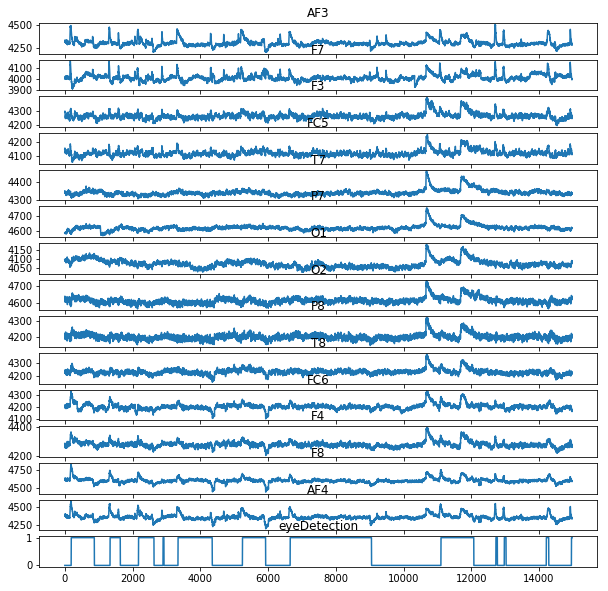

In [46]:
plotFeatures(eegDataNoOutLiers, eegHeader)

In [47]:
# normalize features
scaler = SklPreProcessing.MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(eegDataNoOutLiers)

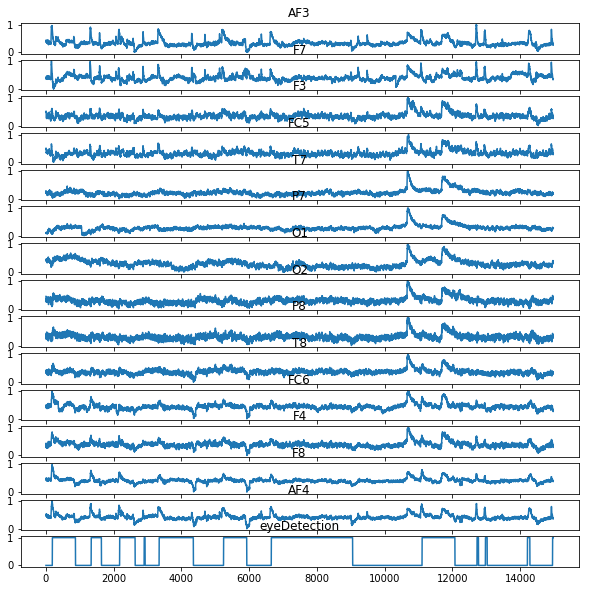

In [48]:
plotFeatures(scaled, eegHeader)

## Start here...

In [49]:
lagValue = 2

scaledWithLag1 = conversion(scaled[:, :-1], scaled[:, -1], eegHeader[:-1], eegHeader[-1], lagValue)

print scaledWithLag1.shape
print scaledWithLag1.values[0, :]
print scaledWithLag1.values[:, -1]

(14974, 45)
[ 0.42880941  0.41224928  0.48640772  0.46793535  0.28709819  0.10483829
  0.46464448  0.44863617  0.43154779  0.40831506  0.47901511  0.40361568
  0.49343604  0.51187141  0.          0.41375143  0.39390322  0.51088972
  0.47059437  0.23545323  0.10756408  0.46805856  0.43612174  0.36608438
  0.3521026   0.46356162  0.39843591  0.48555416  0.48535451  0.
  0.42377919  0.40206145  0.5189974   0.51068822  0.20318299  0.09141899
  0.46464448  0.3832088   0.34820962  0.33007533  0.45917094  0.41143612
  0.47506206  0.49930648  0.        ]
[ 0.  0.  0. ...,  1.  1.  1.]


In [37]:
# splitRatio = 0.05
splitRatio = 0.2
print "Split: ", splitRatio * 100, "-", (100 - (splitRatio * 100))
splitPoint = int(splitRatio * scaledWithLag1.shape[0])

values = scaledWithLag1.values
train = values[:splitPoint, :]
test = values[splitPoint:, :]

# # split into input and outputs
# train_X, train_y = train[:, :-1], train[:, -1]
# test_X, test_y = test[:, :-1], test[:, -1]

# # reshape input to be 3D [samples, timesteps, features]
# train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
# test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))


# # split into train and test sets
# values = reframed.values
# n_train_hours = 365 * 24
# train = values[:n_train_hours, :]
# test = values[n_train_hours:, :]

n_features = len(eegHeader)
print n_features

# split into input and outputs
# n_obs = lagValue * n_features

# print train.shape
# print n_obs

# n_features = 15

# train_X, train_y = train[:, :n_obs], train[:, -n_features]
# test_X, test_y = test[:, :n_obs], test[:, -n_features]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]


print test_X
print train_X.shape


# print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
# # print test_X[:, -1]

# reshape input to be 3D [samples, timesteps, features]
# train_X = train_X.reshape((train_X.shape[0], lagValue, n_features))
# test_X = test_X.reshape((test_X.shape[0], lagValue, n_features))
train_X = train_X.reshape((train_X.shape[0], lagValue, 22))
test_X = test_X.reshape((test_X.shape[0], lagValue, 22))
# print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


Split:  20.0 - 80.0
15
[[ 0.33836355  0.33675581  0.36956176 ...,  0.4374873   0.39107403
   0.47420381]
 [ 0.34339376  0.32859758  0.34237719 ...,  0.45571806  0.41599918
   0.45606353]
 [ 0.35008983  0.35307227  0.35324042 ...,  0.45312817  0.40811731
   0.44771411]
 ..., 
 [ 0.27137024  0.33675581  0.25541837 ...,  0.28905139  0.38055634
   0.36402948]
 [ 0.25794545  0.34284464  0.25271581 ...,  0.33592322  0.39237915
   0.3947075 ]
 [ 0.25964397  0.33878542  0.26087648 ...,  0.37238472  0.39632009
   0.3947075 ]]
(2994, 44)


In [38]:
# design network
model = Sequential()

print (train_X.shape[1], train_X.shape[2])

model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))

model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# Visualize LSTM network
plot_model(model, to_file='model_1.png', show_shapes=True)



(2, 22)


In [39]:
# fit network

print train_X.shape
print train_y.shape

print test_X.shape
print test_y.shape


history = model.fit(train_X, train_y, epochs=50, batch_size=72,
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

# history = model.fit(train_X, train_y, epochs=50, batch_size=10, validation_data=(test_X, test_y), verbose=2, shuffle=False)


# history = model.fit(train_X, train_y, batch_size=10, epochs=100, verbose=2, shuffle=False)
# history = model.fit(train_X, train_y, batch_size=10, epochs=10, verbose=2, shuffle=False)

(2994, 2, 22)
(2994,)
(11980, 2, 22)
(11980,)
Train on 2994 samples, validate on 11980 samples
Epoch 1/50
 - 0s - loss: 0.5252 - val_loss: 0.4169
Epoch 2/50
 - 0s - loss: 0.3955 - val_loss: 0.3161
Epoch 3/50
 - 0s - loss: 0.2499 - val_loss: 0.1349
Epoch 4/50
 - 0s - loss: 0.1174 - val_loss: 0.2778
Epoch 5/50
 - 0s - loss: 0.1284 - val_loss: 0.0567
Epoch 6/50
 - 0s - loss: 0.0912 - val_loss: 0.0621
Epoch 7/50
 - 0s - loss: 0.0767 - val_loss: 0.1015
Epoch 8/50
 - 0s - loss: 0.0682 - val_loss: 0.0811
Epoch 9/50
 - 0s - loss: 0.0583 - val_loss: 0.0572
Epoch 10/50
 - 0s - loss: 0.0473 - val_loss: 0.0845
Epoch 11/50
 - 0s - loss: 0.0650 - val_loss: 0.0496
Epoch 12/50
 - 0s - loss: 0.0556 - val_loss: 0.0394
Epoch 13/50
 - 0s - loss: 0.0477 - val_loss: 0.0455
Epoch 14/50
 - 0s - loss: 0.0419 - val_loss: 0.0482
Epoch 15/50
 - 0s - loss: 0.0395 - val_loss: 0.0534
Epoch 16/50
 - 0s - loss: 0.0408 - val_loss: 0.0409
Epoch 17/50
 - 0s - loss: 0.0428 - val_loss: 0.0309
Epoch 18/50
 - 0s - loss: 0.03

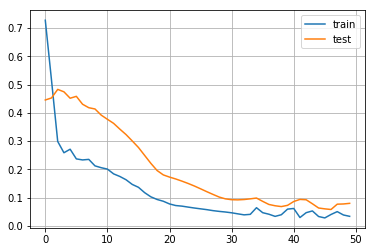

<type 'dict'>
['loss', 'val_loss']


In [54]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.grid()
plt.legend()
plt.show()


print type(history.history)
print history.history.keys()

In [55]:
loss = model.evaluate(test_X, test_y)

print loss

14226/14226 [==============================] - 0s 26us/step
0.0802755817817


[ 1.  1.  1. ...,  1.  1.  1.]


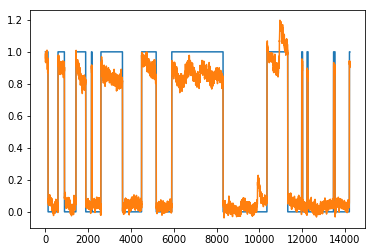

In [60]:
pred = model.predict(test_X)

plt.plot(test_y)
plt.plot(pred)


print test_y

In [61]:
# make a prediction
yhat = model.predict_classes(test_X)
# test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

expected = test_y.astype(int)
measured = yhat.reshape((len(yhat),))

print expected
print measured

# calculate RMSE
rmse = mt.sqrt(SklMetrics.mean_squared_error(expected, measured))
print('Test RMSE: %.3f' % rmse)



[1 1 1 ..., 1 1 1]
[1 1 1 ..., 1 1 1]
Test RMSE: 0.056


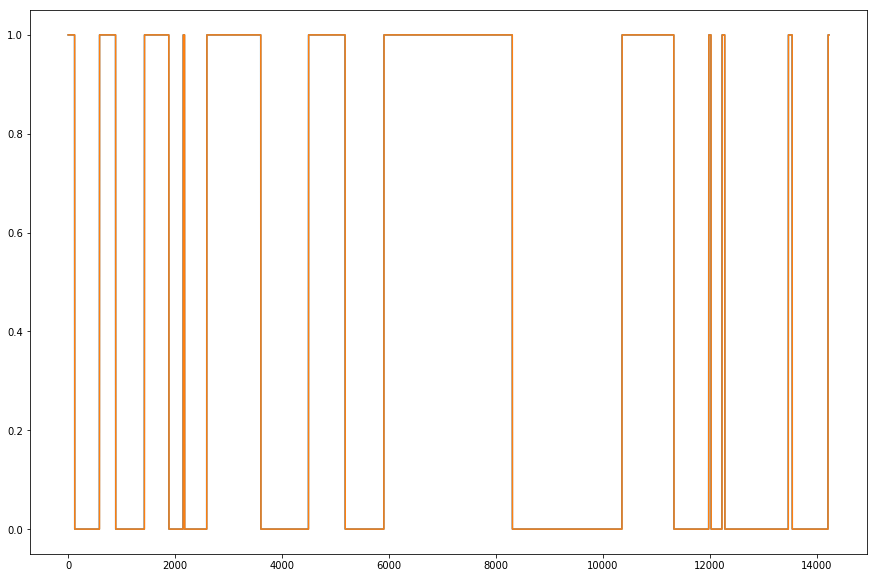

In [62]:
fig = plt.figure()
fig.set_figwidth(15)
fig.set_figheight(10)
plt.plot(expected)
plt.plot(measured)


In [63]:
res = np.where(expected != measured)



print "Indixes where expected != measured: ", res[0]
print "Count where expected != measured:   ", res[0].shape[0]
print "Total test points:                  ", expected.shape[0]

idx = 888
print expected[idx]
print measured[idx]

Indixes where expected != measured:  [  121   122   585   586   887   888  1425  1426  1882  1883  2149  2150
  2176  2177  2591  2592  3601  3602  4493  4494  5177  5178  5902  5903
  8303  8304 10353 10354 11323 11324 11975 11976 12018 12019 12223 12224
 12275 12276 13463 13464 13535 13536 14205 14206]
Count where expected != measured:    44
Total test points:                   14226
0
1


In [64]:
# make a prediction
yhat = model.predict_classes(train_X)

expectedTrainData = train_y.astype(int)
measuredTrainData = yhat.reshape((len(yhat),))

# print expected
# print measured

# calculate RMSE
rmse = mt.sqrt(SklMetrics.mean_squared_error(expectedTrainData, measuredTrainData))
print('Test RMSE: %.3f' % rmse)

res = np.where(expectedTrainData != measuredTrainData)

print "Indixes where expected != measured: ", res[0]
print "Count where expected != measured:   ", res[0].shape[0]
print "Total test points:                  ", expectedTrainData.shape[0]

Test RMSE: 0.052
Indixes where expected != measured:  [186 187]
Count where expected != measured:    2
Total test points:                   748


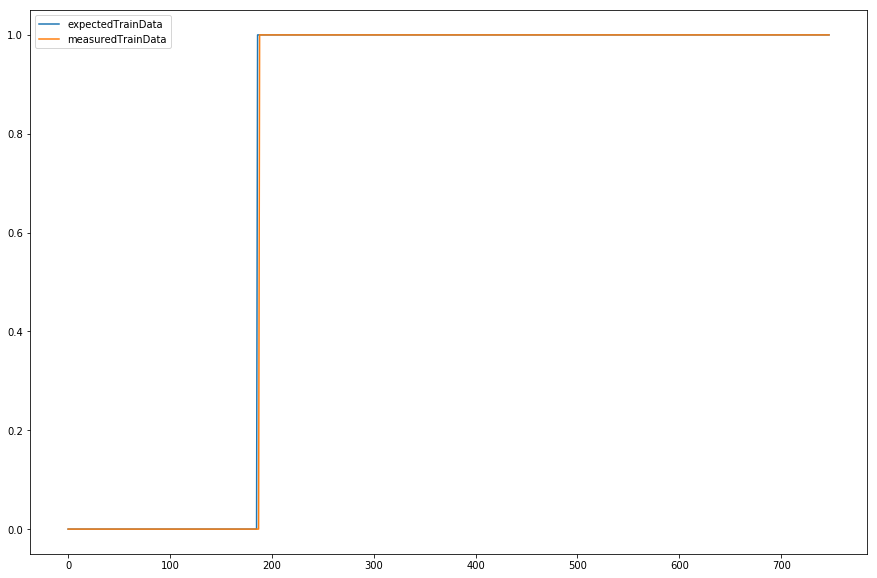

In [65]:
fig = plt.figure()
fig.set_figwidth(15)
fig.set_figheight(10)
plt.plot(expectedTrainData)
plt.plot(measuredTrainData)
plt.legend(['expectedTrainData', 'measuredTrainData'])
